Inputs: Channel coefficients

Outpus: Inverse channel coefficients

Error: L2 norm of vector difference between inverse estimates and actual estimates

## Create training and test data

In [1]:
import numpy as np

# Create training and test data for the NN

# number of random channels that will be trained and tested on
num_train=1000000
num_test=10

# assume we know the channel_length
channel_length = 2

# assume we are working with just real parts
channel_train = np.zeros((num_train,channel_length))
inverse_train = np.zeros((num_train,channel_length))
channel_test = np.zeros((num_test,channel_length))
inverse_test =np.zeros((num_test,channel_length))

for i in range(0, num_train):
    channel_train[i,:]=np.random.uniform(0.2,1,2)
    # if the total power is greater than 1, then normalize
    if sum(channel_train[i])>=1:
        channel_train[i] = channel_train[i]/(sum(channel_train[i]))
    
    inverse_train[i,0] = 1/channel_train[i,0]
    for j in range(1, channel_length):
        inverse_train[i,j] = -channel_train[i,j]
        
        
for i in range(0, num_test):
    channel_test[i,:]=np.random.uniform(0.2,1,2)
    # if the total power is greater than 1, then normalize
    if sum(channel_test[i])>=1:
        channel_test[i] = channel_test[i]/(sum(channel_test[i]))
    
    inverse_test[i,0] = 1/channel_test[i,0]
    for j in range(1, channel_length):
        inverse_test[i,j] = -channel_test[i,j]
        

In [ ]:
channel_test.shape

In [ ]:
import numpy as np
# import commpy as cp
import scipy.signal as sig

# define the number of constellation points
c=4 
# length of array of bits (must be divisible by c)
n=4*c

# create the modulation object with c constellation points
# QAMModem = cp.modulation.QAMModem(c)
# create a random array of bits
input_data_bits=np.random.randint(0,2,n) 
# use the constellation object to modulate the data bits into complex numbers
# input_data_constellations = QAMModem.modulate(input_data_bits)
print('Input data bits',input_data_bits)
# print('Input data constellations',input_data_constellations)

# an example of a channel function with two consecutive taps
channel_function=channel_train[3]
print('Channel function: ', channel_function)
# convolution of the input complex data with the channel transfer function
# channel_output = sig.convolve(input_data_constellations, channel_function, mode='full')
channel_output = sig.convolve(input_data_bits, channel_function, mode='full')

print('Channel output',channel_output)

channel_inversion = inverse_train[3]
equalizer_output = sig.convolve(channel_output, channel_inversion, mode='full')

print('Equalizer output', equalizer_output)

## Simple NN to do channel inversion

/home/laura/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Epoch 0, Cost 3.1964173316955566, MC Cost: 2.8843770027160645
Epoch 100, Cost 0.2004367709159851, MC Cost: 0.26523855328559875
Epoch 200, Cost 0.12041230499744415, MC Cost: 0.1443423330783844
Epoch 300, Cost 0.05108363926410675, MC Cost: 0.03997243568301201
Epoch 400, Cost 0.04993143305182457, MC Cost: 0.031865816563367844
Epoch 500, Cost 0.025084692984819412, MC Cost: 0.013579720631241798
Epoch 600, Cost 0.011015092954039574, MC Cost: 0.002462635049596429
Epoch 700, Cost 0.0035076921340078115, MC Cost: 0.0014392725424841046
Epoch 800, Cost 0.0027044443413615227, MC Cost: 0.0016085223760455847
Epoch 900, Cost 0.002129240892827511, MC Cost: 0.0013587165158241987
Epoch 1000, Cost 0.001772560877725482, MC Cost: 0.0011234795674681664
Epoch 1100, Cost 0.002080019097775221, MC Cost: 0.001055353321135044
Epoch 1200, Cost 0.0020889476872980595, MC Cost: 0.0009121649782173336
Epoch 1300, Cost 0.0015305374981835485, MC Cost: 0.0006902244640514255
Epoch 1400, Cost 0.001191539573483169, MC Cost: 0

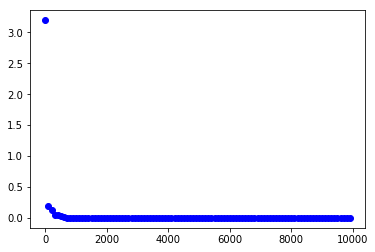

In [2]:
import numpy as np
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
np.random.seed()

m = 2 # of consecutive taps
learning_rate = 0.001
epochs = 10000
batch_size = 1000
test_averaging=100
decay = 1 - 10*1e-10


# declare the training data placeholders
# input x - just one is x0
real_channel = tf.placeholder(tf.float32, [None, m])
real_inverse = tf.placeholder(tf.float32, [None, m])

layer_1 = tf.layers.dense(
  real_channel, 150, tf.nn.tanh, use_bias=True)
layer_2 = tf.layers.dense(
  layer_1, 150, tf.nn.tanh, use_bias=True)
layer_3 = tf.layers.dense(
  layer_2, m, activation=tf.identity, use_bias=True)

inverse_channel = layer_3


adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])

inversion_cost = tf.reduce_mean(tf.reduce_mean((real_inverse-inverse_channel)**2, axis=1))

optimizer = tf.train.AdamOptimizer(learning_rate=adaptive_learning_rate).minimize(inversion_cost)
                                                                                  
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

plt.figure()

# start the session
with tf.Session() as sess:
    #    initialize the variables
    sess.run(init_op)
    mc_losses = []
        
    for epoch in range(epochs):
        
        channel_batch = [1,0]
        real_inv_batch = [1,0]
        for rand in range(0,batch_size-1):
            rand_int = np.random.randint(0,num_train)
            channel_batch = np.vstack((channel_batch, channel_train[rand_int]))
            real_inv_batch = np.vstack((real_inv_batch, inverse_train[rand_int]))
            
        channel_batch = channel_batch.reshape((batch_size, m))
        real_inv_batch = real_inv_batch.reshape((batch_size, m))
        
        _,cost,inverse_channel2 = sess.run([optimizer, inversion_cost, inverse_channel], 
                                          feed_dict={real_channel: channel_batch, real_inverse: real_inv_batch,
                         adaptive_learning_rate: learning_rate * (decay**epoch)})
#         print(LA.norm(real_inv_batch-inverse_channel))
        
            
        if epoch % 100 == 0: 
            plt.plot(epoch, cost, 'bo')
            mc_cost, mc_inversion = sess.run([inversion_cost, inverse_channel], 
                                             feed_dict={real_channel: channel_test, 
                                                        real_inverse: inverse_test})
            print('Epoch {}, Cost {}, MC Cost: {}'.format(epoch, cost, mc_cost))

    
plt.show()


In [ ]:
print(mc_inversion)

print(inverse_test)

print(LA.norm(mc_inversion-inverse_test))

## Search over architectures to find NN to learn how to invert the channel coefficients

In [ ]:

import tensorflow as tf
from tqdm import tqdm
import numpy as np
import uuid
import sys
import scipy.stats 
import matplotlib
import itertools 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os 
import pickle

import timeit

start = timeit.default_timer()

NUMSTEPS = 20 #For printing and saving to tensorboard

NUMBATCHESTESTING = 100 #Number of batches for testing
UNIQUEID=  uuid.uuid1().__str__()[:6]
# TENSORBOARDPATH = "tensorboard-layers-api/basic_" 
# RESULTSFILEPATH = "1d/results/dat/basic_"  
# METARESULTSFILEPATH = "1d/results/meta_basic_1"  #WARNING: CHANGE THIS FOR DIFFERENT RUNS
# FIGPATH = "1d/figures/basic_"+ UNIQUEID
# CHECKPOINTPATH = "1d/checkpoints/basic_" + UNIQUEID   


############## 
#Helper functions
##############

def cartesian_product(*arrays): 
    return itertools.product(*arrays)


def list_to_str(prefix, cur_list):
    cur_list_str = [prefix+str(elem) for elem in cur_list]
    return cur_list_str
    
    
def tup_to_str(tups):
    cur_str = ""
    for k,tup in enumerate(tups):
        cur_str += str(tup)
        if k != len(tups)-1:
            cur_str+=','
    return cur_str

def variable_summaries(var_str, var):
    '''Attach a lot of summaries to a Tensor (for TensorBoard visualization).'''
    with tf.name_scope('summaries'):
        tf.summary.scalar('norm_'+var_str, tf.norm(var))


def neural_net(param_string="", params={}, verbose=False, m=2):

    '''m= channel_length, default 2
        param_string: String encoding information about hyperparameters
       
       params: parameter dictionary that contains
       num_batches: number of batches 
       batch_size: number of samples per batch
       optimizer: the optimizer used to minimize cost
    '''
    tf.reset_default_graph()
  
    global_layer_num = 1
    
    seed = params['seed']
    np.random.seed(seed)
    tf.set_random_seed(seed)

    #Learning rate and optimizer
    optimizer_function = params['optimizer_function']
    learning_rate = float(params['learning_rate'])

    #Placeholders for inputs
    coefs = tf.placeholder(tf.float32, [None, m])
    real_inv = tf.placeholder(tf.float32, [None, m])
#     z = tf.placeholder(tf.float32, [None, m])
    adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])
    


    ###################################################
    #Layers
    ####################################################

    #The layers   
    layer_structures  = params['layer_structures']
    ##########################        
    #First layer structure
    ##########################
    layer_structure = layer_structures[0]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = coefs #Input to first layer of this structure
    for k in range(num_layers):
        net = tf.layers.dense(inputs=net, units=num_units, activation=layer_activation , use_bias=True, 
                              name = 'layer' + str(global_layer_num),
                              kernel_initializer=tf.glorot_normal_initializer())
        
        #Add to tensor board summary
        with tf.variable_scope('layer' + str(global_layer_num), reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)

        global_layer_num += 1       
    h1 = net

    ############################        
    #Second layer structure
    ############################

    layer_structure = layer_structures[1]
    num_units = layer_structure[0]
    layer_activation = layer_structure[1]
    num_layers = layer_structure[2]
    net = h1 #Input to first layer of this structure
    for k in range(num_layers):
        net = tf.layers.dense(inputs=net, units=m, activation=layer_activation,use_bias=True, 
                              name = 'layer' + str(global_layer_num),
                              kernel_initializer=tf.glorot_normal_initializer())
        #Add to tensor board summary
        with tf.variable_scope('layer' + str(global_layer_num), reuse=True):
            with tf.name_scope('weights'):
                w = tf.get_variable('kernel')
                b = tf.get_variable('bias')
                variable_summaries('w'+str(global_layer_num), w)
                variable_summaries('b'+str(global_layer_num), b)
        global_layer_num += 1    
    inverse = net

    cost = tf.reduce_mean(tf.reduce_mean((inverse-real_inv)**2,axis=1))
    optimizer = optimizer_function(adaptive_learning_rate).minimize(cost)

    ###################
    #Tensor board summary
    ####################
    tf.summary.scalar("cost", cost)
    tf.summary.scalar("adaptive_learning_rate", adaptive_learning_rate)
    merged_summary_op = tf.summary.merge_all()   


    ######################################
    #Session
    #####################################
    with tf.Session() as sess:

        #Creates/saves in directory named tensorboard-layers-api in same directory as the .ipynb
#         uniq_id = TENSORBOARDPATH +  UNIQUEID +"/" + param_string
#         summary_writer = tf.summary.FileWriter(uniq_id, graph=tf.get_default_graph())


        #######################################
        #Training
        #Train the nn on training set constructed by sampling x0 and z independently from gaussian
        #distributions with means 0 and standard deviations sigma_x0 and sigma_z respectively
        #######################################

        if verbose is True:
            print("Training...")

        #Initialization
        init_op = tf.global_variables_initializer()
        sess.run(init_op) 
        
        run_num = params['run_num']
        #Save initializations to file
        saver = tf.train.Saver()
#         cur_checkpoint_path = params['checkpoint_path']
#         saver.save(sess, cur_checkpoint_path)

        batch_size = params['batch_size']
        max_epochs = params['max_epochs']
        learning_rate_decay= float(params['learning_rate_decay'])

        step_size= np.ceil(max_epochs/NUMSTEPS) #For printing and saving to tensor board

        ''''''
        train_costs = np.zeros((max_epochs,1))
        current_start=0
        for step in range(max_epochs): #Splitting into multiple batches so as to not run into memory issues
            batch_coefs = channel_train[current_start:(current_start+batch_size),:]
            batch_real_inv = inverse_train[current_start:(current_start+batch_size),:]
            current_start=current_start+batch_size

            #Adaptive learning rate 
            cur_adaptive_learning_rate = learning_rate*float(learning_rate_decay**step)


            _,batch_cost,summary = sess.run([optimizer,cost,merged_summary_op],       
                        feed_dict = {coefs:batch_coefs, real_inv:batch_real_inv, 
                                     adaptive_learning_rate:cur_adaptive_learning_rate})
            train_costs[step] = batch_cost

            if step % step_size == 0: 
#                 summary_writer.add_summary(summary, step)
                if verbose is True:
                    print("---Step: {}, Cost: {}".format(step,batch_cost))
        
        #Save final weights
#         final_checkpoint_path = params['final_checkpoint_path']
#         saver.save(sess, final_checkpoint_path)

        ######################################
        #Testing on sampled Gaussians
        #Evaluate the nn on test set constructed by sampling x0 and z independently from gaussian
        #distributions  with means 0 and standard deviations sigma_x0 and sigma_z respectively            
        ######################################################
        if verbose is True:
            print("Evaluating on sampled gaussians...")
        num_batches = params['num_batches']
        batch_size = params['batch_size']
        ''''''
        test_costs = np.zeros((num_batches,1))
        current_start=current_start+batch_size
        for i in range(num_batches): #Splitting into multiple batches so as to not run into memory issues
            batch_coefs = channel_test[current_start:(current_start+batch_size),:]
            batch_real_inv = inverse_test[current_start:(current_start+batch_size),:]
            current_start=current_start+batch_size

            batch_cost = sess.run(cost, feed_dict = {coefs:batch_coefs, real_inv:batch_real_inv})
            test_costs[i] = batch_cost
            if verbose is True:
                if i % step_size == 0:
                    print("---Batch: {}, Cost: {}".format(i,batch_cost))

        avg_test_cost = float(np.mean(test_costs, axis = 0))
        if verbose is True:
            print("Average test cost: {}".format(avg_test_cost))
        
        ##########################################################################
        ###Test over representative x0 and z landscape to get complete picture
        ##########################################################################
        
        

        return avg_test_cost



# def main():
#######
#Cartesian product to get the layer structures
######
#First find tuples for different types of layers

hidden_units_type1 = [8,16,32]
hidden_units_type1_str= list_to_str('hu_',hidden_units_type1)

activations_type1 = [tf.nn.tanh, tf.nn.sigmoid]
activations_type1_str = ['tanh', 'sigmoid', 'relu']

num_layers_type1 = [1,2]
num_layers_type1_str = list_to_str('nu_',num_layers_type1)


m=2
hidden_units_type2 = [m]
hidden_units_type2_str= list_to_str('hu_',hidden_units_type2)
activations_type2 = [tf.identity]
activations_type2_str = ['identity']
num_layers_type2= [1]
num_layers_type2_str = list_to_str('nu_',num_layers_type2)

layers_type1 = cartesian_product(hidden_units_type1, activations_type1, num_layers_type1)
layers_type1_str = ['ls1_' + tup_to_str(tup) for tup in cartesian_product(hidden_units_type1_str, 
                                                                          activations_type1_str, 
                                                                          num_layers_type1_str)]


layers_type2 = cartesian_product(hidden_units_type2, activations_type2, num_layers_type2)
layers_type2_str = ['ls2_'+tup_to_str(tup) for tup in cartesian_product(hidden_units_type2_str, 
                                                                        activations_type2_str, 
                                                                        num_layers_type2_str)]

layers = cartesian_product(layers_type1, layers_type2)

layers_str = [tup_to_str(tup) for tup in cartesian_product(layers_type1_str, layers_type2_str)]

#Next find tuples for the whole parameter space
learning_rates = [1e-3,1e-2, 1e-1]
learning_rates_str = ['lr_'+str(elem) for elem in learning_rates]
learning_rate_decays = [1.-1e-9]
learning_rate_decays_str = ['1-1e-9']
max_epochs = [1000]
max_epochs_str = ['me_' + str(elem) for elem in max_epochs]
batch_sizes = [1000]
batch_sizes_str = ['bsz_' +str(elem) for elem in batch_sizes]

given_seeds = np.arange(10)
given_seeds_str = [str(elem) for elem in given_seeds]

optimizer_functions = [tf.train.AdamOptimizer]
optimizer_functions_str = ['Adam']

hyperparam_tuples = list(cartesian_product(layers, learning_rates, learning_rate_decays,max_epochs, 
                                           batch_sizes, optimizer_functions, given_seeds))
hyperparam_tuples_str = [tup_to_str(tup) for tup in list(cartesian_product(layers_str, learning_rates_str, 
                                                                           learning_rate_decays_str, 
                                                                           max_epochs_str,batch_sizes_str, 
                                                                           optimizer_functions_str, 
                                                                           given_seeds_str))]


##################
#Main Loop
 ##################


# meta_results_file = METARESULTSFILEPATH + '.txt'

# with open(meta_results_file, 'w') as f:
#    f.write(UNIQUEID + '\n')
#    f.close()

hyperparam_results_list = []
for k,tup in enumerate(tqdm(hyperparam_tuples)):

#    if k > 1000:
#     continue
   layer_structure = tup[0]
   learning_rate = tup[1]
   learning_rate_decay = tup[2]
   max_epoch = tup[3]
   batch_size = tup[4]
   optimizer_function = tup[5]
   seed = tup[6]


#    checkpoint_path = CHECKPOINTPATH + "/model_" + str(k) + ".ckpt"
#    final_checkpoint_path = CHECKPOINTPATH + "/final_model_" + str(k) + ".ckpt"
  
   tup_str = hyperparam_tuples_str[k]
   params = {'run_num':k, 
             'seed':seed, 'num_batches':NUMBATCHESTESTING, 'batch_size':batch_size, 
             'optimizer_function':optimizer_function, 'learning_rate':learning_rate, 
             'max_epochs':max_epoch,'learning_rate_decay':learning_rate_decay, 
             'layer_structures':layer_structure}

   print(tup_str)
#         avg_test_cost, avg_test_cost_rep, x0_test_rep, u1_test_rep, u2_test_rep, x1_test_rep, x2_test_rep =    
#neural_net(param_string= tup_str, params=params, verbose = True)   
   

   avg_test_cost = neural_net(param_string= tup_str, params=params, verbose = True,m = m)   
   

   
#    avg_cost_test_rep = np.sum(cost_test_rep*x_density)/np.sum(x_density)
   
#    hyperparam_results_dict = {}
#    hyperparam_results_dict['tup_str'] = tup_str
#    hyperparam_results_dict['tup'] = tup
#    hyperparam_results_dict['cost'] = cost_test_rep
#    hyperparam_results_dict['x1'] = x1_test_rep
#    hyperparam_results_dict['x2']= x2_test_rep
#    hyperparam_results_dict['x0'] = x_grid
#    hyperparam_results_dict['u2']= u2_test_rep
#    hyperparam_results_dict['params'] = params
   
#    hyperparam_results_list.append([avg_cost_test_rep, hyperparam_results_dict])
   
   
#    results_file = RESULTSFILEPATH + UNIQUEID + "_" + str(k) + '.dat'
   
#    with open(results_file, 'wb') as f:
#        pickle.dump(hyperparam_results_dict,f)
#        f.close()
   
#    with open(meta_results_file, 'a') as f:
#        f.write(str(k) + " " + results_file + " " + checkpoint_path + " " + final_checkpoint_path + " " +  str(avg_cost_test_rep) + " " + tup_str +  '\n')

    
stop = timeit.default_timer()

print ("compute time: ", stop - start)

In [ ]:
inverse_train[0:3,:]